# Yelp Review Classifier

A basic NLP project that classifies Yelp reviews as either 1-star or 5-star based on the review text using a Naive Bayes classifier.

## 🔍 Overview

This project demonstrates how natural language processing can be used to identify review sentiment. It includes two modeling approaches:
- A bag-of-words model using `CountVectorizer`
- A pipeline that adds `TF-IDF` weighting

Surprisingly, adding TF-IDF **reduced the model's performance**, showcasing that simpler models can sometimes be more effective in certain contexts.

## 🚀 Features

- Text length feature analysis
- Visualizations: histograms, boxplots, countplots, heatmaps
- Binary classification (1-star vs. 5-star reviews)
- Comparison of BoW and TF-IDF transformations
- Model evaluation with confusion matrix and classification report

## 🛠 Tools & Libraries

- Python 3
- pandas, numpy
- matplotlib, seaborn
- scikit-learn

## 📁 Dataset

[Yelp Review Dataset – Kaggle](https://www.kaggle.com/datasets/yelp-dataset/yelp-dataset)  
Used 10,000 reviews with accompanying star ratings.

## 📌 How to Use

1. Load `yelp.csv` into the notebook or script.
2. Run EDA and visualizations.
3. Train models on reviews labeled 1⭐ or 5⭐.
4. Evaluate model performance, compare BoW vs. TF-IDF pipelines.

## 🧪 Results

- **CountVectorizer model accuracy:** ~92%
- **TF-IDF pipeline performance dropped**, misclassifying all 1-star reviews.
- Emphasizes the importance of evaluating preprocessing techniques in context.

## 📌 Note

TF-IDF isn't always the better choice—especially when raw frequency provides stronger signal. Always validate with experiments!

In [1]:
# Importing essential libraries for data manipulation and visualization
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns

# Ensures plots display inline in notebooks
%matplotlib inline

In [2]:
# Ensures plots display inline in notebooks
yelp = pd.read_csv('yelp.csv')

In [3]:
# Display the first two rows to preview the data structure
yelp.head(2)

,business_id,date,review_id,stars,text,type,user_id,cool,useful,funny
0,9yKzy9PApeiPPOUJEtnvkg,2011-01-26,fWKvX83p0-ka4JS3dc6E5A,5,My wife took me here on my birthday for breakf...,review,rLtl8ZkDX5vH5nAx9C3q5Q,2,5,0
1,ZRJwVLyzEJq1VAihDhYiow,2011-07-27,IjZ33sJrzXqU-0X6U8NwyA,5,I have no idea why some people give bad review...,review,0a2KyEL0d3Yb1V6aivbIuQ,0,0,0


In [4]:
# Get info on data types and missing values
yelp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   business_id  10000 non-null  object
 1   date         10000 non-null  object
 2   review_id    10000 non-null  object
 3   stars        10000 non-null  int64 
 4   text         10000 non-null  object
 5   type         10000 non-null  object
 6   user_id      10000 non-null  object
 7   cool         10000 non-null  int64 
 8   useful       10000 non-null  int64 
 9   funny        10000 non-null  int64 
dtypes: int64(4), object(6)
memory usage: 781.4+ KB


In [5]:
# Generate basic statistics for numeric columns
yelp.describe()

,stars,cool,useful,funny
count,10000.000000,10000.000000,10000.000000,10000.000000
mean,3.777500,0.876800,1.409300,0.701300
std,1.214636,2.067861,2.336647,1.907942
min,1.000000,0.000000,0.000000,0.000000
25%,3.000000,0.000000,0.000000,0.000000
50%,4.000000,0.000000,1.000000,0.000000
75%,5.000000,1.000000,2.000000,1.000000
max,5.000000,77.000000,76.000000,57.000000


# ---------------------- Exploratory Data Analysis ----------------------

In [6]:
# Create a new feature: length of each review text
yelp['text length'] = yelp['text'].apply(len)

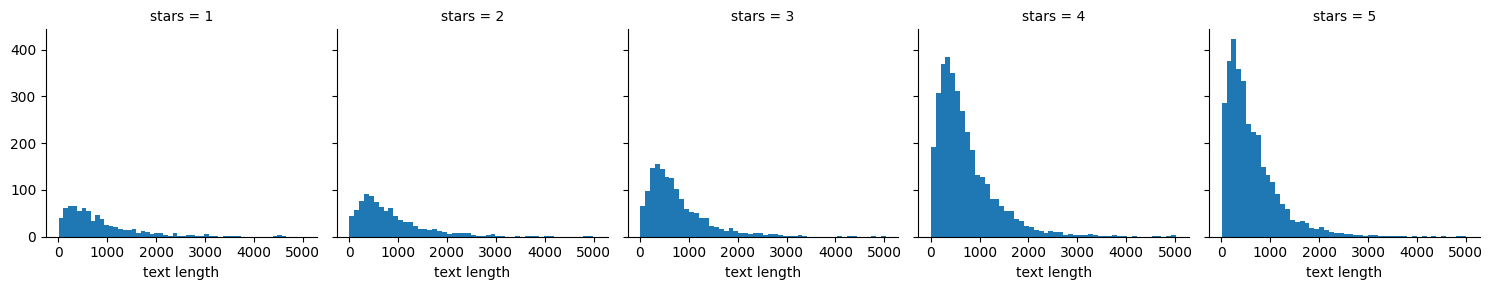

In [7]:
# Visualize distribution of text length across different star ratings
g = sns.FacetGrid(yelp, col='stars')
g.map(plt.hist, 'text length', bins=50)
plt.show()

In [8]:
# Suppress warning messages for clean output
import warnings
warnings.filterwarnings('ignore')

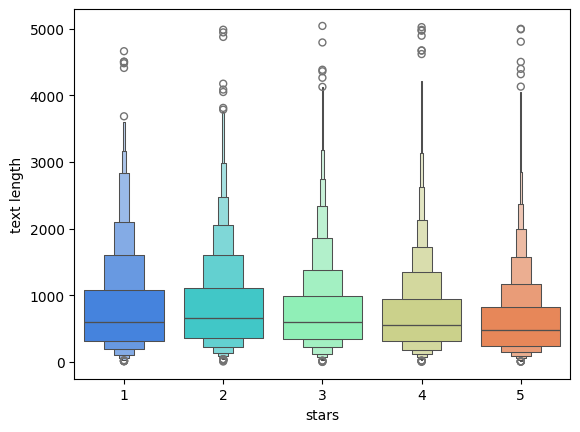

In [9]:
#  Visualize the spread of text lengths with respect to star ratings using a boxenplot 
sns.boxenplot(x = 'stars', y = 'text length', data = yelp, palette='rainbow')
plt.show()

<Axes: xlabel='stars', ylabel='count'>

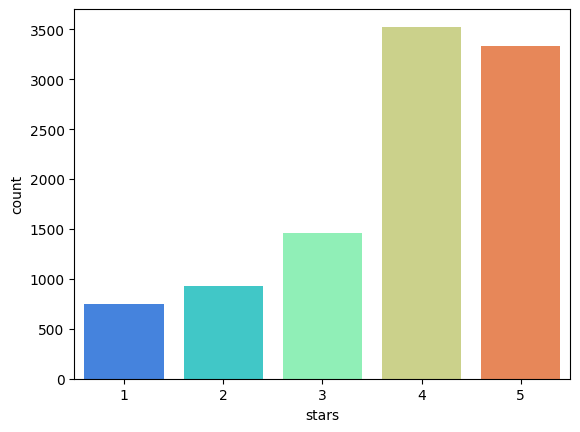

In [10]:
# Countplot to show how many reviews exist for each star rating 
sns.countplot(x = 'stars', data = yelp, palette='rainbow')

In [11]:
# Group by star rating and calculate mean of numeric features
stars = yelp.groupby('stars').mean(numeric_only=True)
stars

,cool,useful,funny,text length
stars,,,,
1,0.576769,1.604806,1.056075,830.244326
2,0.719525,1.563107,0.875944,846.249191
3,0.788501,1.306639,0.694730,762.325120
4,0.954623,1.395916,0.670448,716.493193
5,0.944261,1.381780,0.608631,627.976925


In [12]:
# Compute correlations between numerical features
stars.corr()

,cool,useful,funny,text length
cool,1.000000,-0.743329,-0.944939,-0.856995
useful,-0.743329,1.000000,0.894506,0.698743
funny,-0.944939,0.894506,1.000000,0.842585
text length,-0.856995,0.698743,0.842585,1.000000


<Axes: >

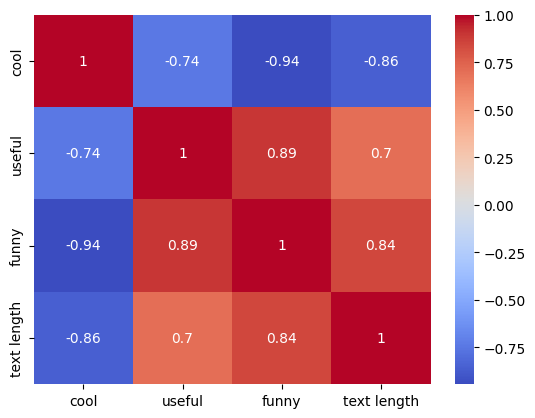

In [13]:
# Visualize correlation matrix with a heatmap
sns.heatmap(stars.corr(), cmap='coolwarm', annot=True)

# ---------------------- NLP Classification ----------------------

In [14]:
# Focus only on reviews with extreme ratings: 1 star or 5 stars
yelp_class = yelp[(yelp['stars'] == 1) | (yelp['stars'] == 5)]

In [15]:
yelp_class.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4086 entries, 0 to 9999
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   business_id  4086 non-null   object
 1   date         4086 non-null   object
 2   review_id    4086 non-null   object
 3   stars        4086 non-null   int64 
 4   text         4086 non-null   object
 5   type         4086 non-null   object
 6   user_id      4086 non-null   object
 7   cool         4086 non-null   int64 
 8   useful       4086 non-null   int64 
 9   funny        4086 non-null   int64 
 10  text length  4086 non-null   int64 
dtypes: int64(5), object(6)
memory usage: 383.1+ KB


In [16]:
# Define features and labels
X = yelp_class['text'] # features
y = yelp_class['stars'] # labels

In [17]:
# Convert text data into a bag-of-words format
from sklearn.feature_extraction.text import CountVectorizer
cv = CountVectorizer()

In [18]:
# Convert the text data into a matrix of token counts (bag-of-words representation)
X = cv.fit_transform(X)

# ---------------------- Train/Test Split ----------------------

In [19]:
from sklearn.model_selection import train_test_split

In [20]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=101)

# ---------------------- Model Training ----------------------

In [21]:
# Instantiate and train a Naive Bayes classifier
from sklearn.naive_bayes import MultinomialNB

In [22]:
nb = MultinomialNB()

In [23]:
nb.fit(X_train, y_train)

MultinomialNB()

In [24]:
# Predict labels for the test data
prediction = nb.predict(X_test)

In [25]:
# Evaluate model performance
from sklearn.metrics import confusion_matrix, classification_report 

In [26]:
print(confusion_matrix(y_test, prediction))

[[159  69]
 [ 22 976]]


In [27]:
print(classification_report(y_test, prediction))

              precision    recall  f1-score   support

           1       0.88      0.70      0.78       228
           5       0.93      0.98      0.96       998

    accuracy                           0.93      1226
   macro avg       0.91      0.84      0.87      1226
weighted avg       0.92      0.93      0.92      1226



# ---------------------- Text Processing with TF-IDF ----------------------

In [28]:
# Import text preprocessing and modeling tools
from sklearn.feature_extraction.text import TfidfTransformer

In [29]:
from sklearn.pipeline import Pipeline

IDF (Inverse Document Frequency): How unique that word is across all documents.

In [30]:
# Create a pipeline: CountVectorizer -> TfidfTransformer -> Naive Bayes
pipe = Pipeline([
    ('bow', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('model', MultinomialNB())
])

In [31]:
# Redefine text features and labels for the pipeline
X = yelp_class['text']
y = yelp_class['stars']
# Redefine text features and labels for the pipeline
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=101)

In [32]:
# Fit the pipeline on the training data
pipe.fit(X_train, y_train)

Pipeline(steps=[('bow', CountVectorizer()), ('tfidf', TfidfTransformer()),
                ('model', MultinomialNB())])

Predictions and Evaluations 

In [33]:
# Predict using the pipeline on test data
predictions = pipe.predict(X_test)

In [34]:
print(confusion_matrix(y_test, predictions))

[[  0 228]
 [  0 998]]


In [35]:
# Evaluate performance of the pipeline model
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           1       0.00      0.00      0.00       228
           5       0.81      1.00      0.90       998

    accuracy                           0.81      1226
   macro avg       0.41      0.50      0.45      1226
weighted avg       0.66      0.81      0.73      1226



LOOK's LIKE TFIDF ACTUALLY MADE THINGS WORSE!